In [1]:
!pip install numpy matplotlib tqdm

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
train_a_dir = "cartoon_people/trainA"
train_b_dir = "cartoon_people/trainB"

val_a_dir = "cartoon_people/testA"
val_b_dir = "cartoon_people/testB"

In [3]:
!mv *.jpg cartoon_people/testB/

In [ ]:
!mv *.png cartoon_people/testA_to_B/

In [52]:
!ls cartoon_people/trainA_to_B/ | wc -l

1408


In [16]:
from PIL import Image
from tqdm import tqdm
import os

def load_images(source_dir, limit=None):
    images = []

    sum_pixels = []
    sum_sq_pixels = []
    n_pixels = []

    pixels = []

    files = os.listdir(source_dir)
    if limit is not None:
        files = files[:limit]
    for filename in tqdm(files):
        filepath = os.path.join(source_dir, filename)
        with Image.open(filepath) as img:
            img = img.convert('RGB')
            img_array = np.array(img)
            #print(img_array.min(), img_array.max(), img_array.dtype)
            images.append(img_array)
    return images

def compute_stats(images):
    n_pixels = sum(img.shape[0] * img.shape[1] for img in images)
    pixels = np.empty((3, n_pixels))

    offset = 0
    for image in tqdm(images):
        pixels[:, offset:offset+image.shape[0]*image.shape[1]] = image.reshape(-1, 3).T
        offset += image.shape[0] * image.shape[1]

    return np.mean(pixels, axis=1), np.std(pixels, axis=1)

In [ ]:
train_a_images = load_images(train_a_dir, limit=1000)
train_a_mean, train_a_std = compute_stats(train_a_images)
train_b_images = load_images(train_b_dir, limit=1000)
train_b_mean, train_b_std = compute_stats(train_b_images)

val_a_images = load_images(val_a_dir)
val_b_images = load_images(val_b_dir)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 1627.90it/s]


In [ ]:
def transfer_stats(source_images, source_stats, target_stats):
    source_mean, source_std = source_stats
    target_mean, target_std = target_stats

    out_images = []
    for img in tqdm(source_images):
        out_img = (target_std.reshape(1, 1, 3) * (img - source_mean.reshape(1, 1, 3)) / source_std.reshape(1, 1, 3) + target_mean.reshape(1, 1, 3)).astype(np.uint8)
        out_images.append(out_img)
    return out_images

In [ ]:
train_a_images = load_images(train_a_dir)

train_a_images_to_b = transfer_stats(train_a_images, (train_a_mean, train_a_std), (train_b_mean, train_b_std))
val_a_images_to_b = transfer_stats(val_a_images, (train_a_mean, train_a_std), (train_b_mean, train_b_std))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 267/267 [00:18<00:00, 14.55it/s]


Text(0.5, 1.0, 'Stds (/256)')

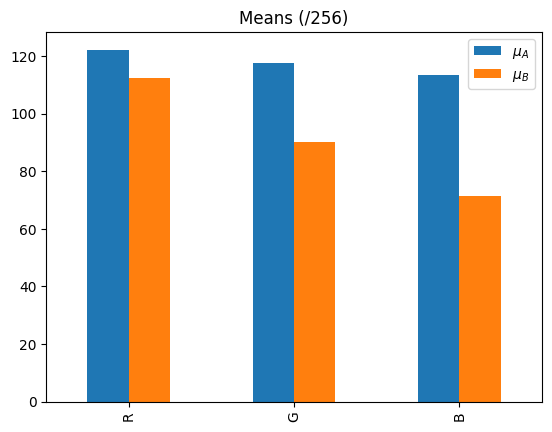

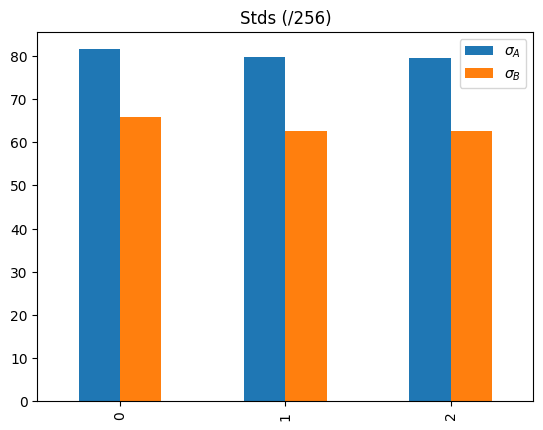

In [ ]:
import pandas as pd

means = pd.DataFrame({
    "$\mu_A$": train_a_mean,
    "$\mu_B$": train_b_mean,
}, index=["R", "G", "B"])

stds = pd.DataFrame({
    "$\sigma_A$": train_a_std,
    "$\sigma_B$": train_b_std,
}, index=["R", "G", "B"])

means.plot.bar()
plt.title("Means (/256)")

stds.plot.bar()
plt.title("Stds (/256)")

In [ ]:
def plot(i):
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(val_a_images[i])
    axs[0].set_title("A")
    axs[1].imshow(val_a_images_to_b[i])
    axs[1].set_title("A with B style")
    plt.show()

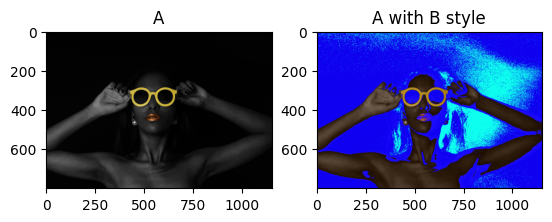

In [ ]:
plot(0)

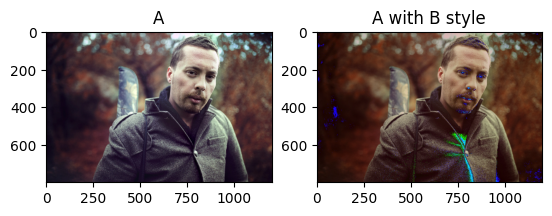

In [ ]:
plot(1)

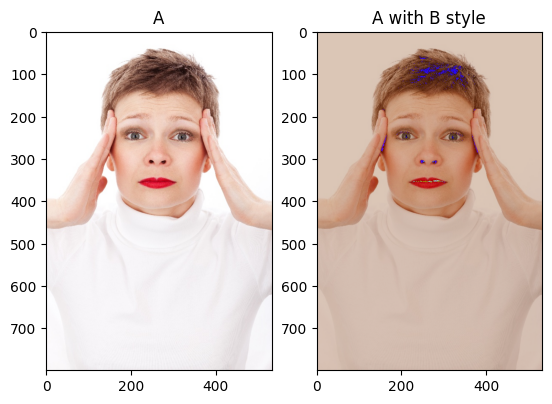

In [ ]:
plot(2)

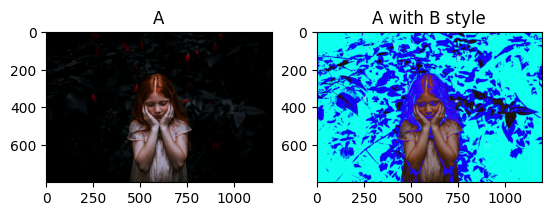

In [ ]:
plot(3)

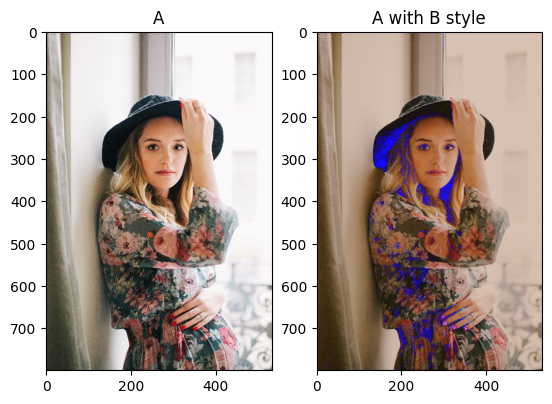

In [ ]:
plot(4)

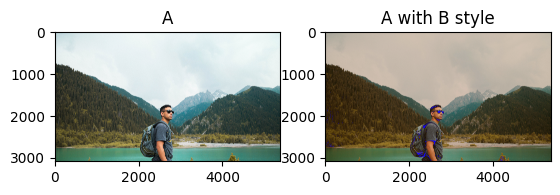

In [ ]:
plot(5)

In [ ]:
def save_images(images, source_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    files = os.listdir(source_dir)
    for img_array, filename in tqdm(zip(images, files)):
        filepath = os.path.join(output_dir, filename)
        img = Image.fromarray(img_array, 'RGB')
        img.save(filepath)

In [ ]:
save_images(train_a_images_to_b, train_a_dir, "cartoon_people/trainA_to_B")
save_images(val_a_images_to_b, val_a_dir, "cartoon_people/valA_to_B")

1000it [08:49,  1.89it/s]
267it [02:43,  1.63it/s]


In [17]:
!pip install clean-fid
from cleanfid import fid

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [21]:
# prompt: list over dir with .jpg images and save them as png

import os
from PIL import Image

def convert_jpg_to_png(source_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for filename in tqdm(os.listdir(source_dir)):
        if filename.endswith(".jpg"):
            filepath = os.path.join(source_dir, filename)
            try:
                with Image.open(filepath) as img:
                    # Change the extension to .png
                    output_filename = os.path.splitext(filename)[0] + ".png"
                    output_filepath = os.path.join(output_dir, output_filename)
                    img.save(output_filepath, "PNG")
                    print(f"Converted {filename} to {output_filename}")
            except Exception as e:
                print(f"Could not convert {filename}: {e}")

convert_jpg_to_png("cartoon_people/testB",  "cartoon_people/testB_png")

 32%|███▏      | 10/31 [00:00<00:00, 45.30it/s]

Converted 3. Зима в Простоквашино_f14525.jpg to 3. Зима в Простоквашино_f14525.png
Converted 1. Трое из Простоквашино_f10825.jpg to 1. Трое из Простоквашино_f10825.png
Converted 2. Каникулы в Простоквашино_f05675 - Copy.jpg to 2. Каникулы в Простоквашино_f05675 - Copy.png
Converted 3. Зима в Простоквашино_f05200.jpg to 3. Зима в Простоквашино_f05200.png
Converted 3. Зима в Простоквашино_f00800.jpg to 3. Зима в Простоквашино_f00800.png
Converted 3. Зима в Простоквашино_f11100.jpg to 3. Зима в Простоквашино_f11100.png
Converted 1. Трое из Простоквашино_f01800.jpg to 1. Трое из Простоквашино_f01800.png
Converted 2. Каникулы в Простоквашино_f03925 - Copy.jpg to 2. Каникулы в Простоквашино_f03925 - Copy.png
Converted 3. Зима в Простоквашино_f04375.jpg to 3. Зима в Простоквашино_f04375.png
Converted 3. Зима в Простоквашино_f14825.jpg to 3. Зима в Простоквашино_f14825.png


 48%|████▊     | 15/31 [00:00<00:00, 44.99it/s]

Converted 3. Зима в Простоквашино_f07075.jpg to 3. Зима в Простоквашино_f07075.png
Converted 2. Каникулы в Простоквашино_f18775.jpg to 2. Каникулы в Простоквашино_f18775.png
Converted 1. Трое из Простоквашино_f08550.jpg to 1. Трое из Простоквашино_f08550.png
Converted 2. Каникулы в Простоквашино_f04025 - Copy.jpg to 2. Каникулы в Простоквашино_f04025 - Copy.png
Converted 2. Каникулы в Простоквашино_f20375.jpg to 2. Каникулы в Простоквашино_f20375.png
Converted 2. Каникулы в Простоквашино_f17800.jpg to 2. Каникулы в Простоквашино_f17800.png
Converted 1. Трое из Простоквашино_f13700.jpg to 1. Трое из Простоквашино_f13700.png
Converted 3. Зима в Простоквашино_f18375.jpg to 3. Зима в Простоквашино_f18375.png
Converted 1. Трое из Простоквашино_f04825.jpg to 1. Трое из Простоквашино_f04825.png


 81%|████████  | 25/31 [00:00<00:00, 45.93it/s]

Converted 3. Зима в Простоквашино_f19500.jpg to 3. Зима в Простоквашино_f19500.png
Converted 1. Трое из Простоквашино_f01875.jpg to 1. Трое из Простоквашино_f01875.png
Converted 1. Трое из Простоквашино_f25050.jpg to 1. Трое из Простоквашино_f25050.png
Converted 2. Каникулы в Простоквашино_f05825 - Copy.jpg to 2. Каникулы в Простоквашино_f05825 - Copy.png
Converted 2. Каникулы в Простоквашино_f24400.jpg to 2. Каникулы в Простоквашино_f24400.png
Converted 3. Зима в Простоквашино_f09900.jpg to 3. Зима в Простоквашино_f09900.png
Converted 3. Зима в Простоквашино_f07775.jpg to 3. Зима в Простоквашино_f07775.png
Converted 2. Каникулы в Простоквашино_f24150.jpg to 2. Каникулы в Простоквашино_f24150.png
Converted 2. Каникулы в Простоквашино_f07225 - Copy.jpg to 2. Каникулы в Простоквашино_f07225 - Copy.png
Converted 1. Трое из Простоквашино_f03450.jpg to 1. Трое из Простоквашино_f03450.png


100%|██████████| 31/31 [00:00<00:00, 45.85it/s]

Converted 1. Трое из Простоквашино_f11150.jpg to 1. Трое из Простоквашино_f11150.png
Converted 1. Трое из Простоквашино_f18400.jpg to 1. Трое из Простоквашино_f18400.png


In [30]:
convert_jpg_to_png("cartoon_people/trainB",  "cartoon_people/trainB_png")

  4%|▎         | 10/275 [00:00<00:05, 46.86it/s]

Converted 1. Трое из Простоквашино_f21000.jpg to 1. Трое из Простоквашино_f21000.png
Converted 1. Трое из Простоквашино_f03800.jpg to 1. Трое из Простоквашино_f03800.png
Converted 3. Зима в Простоквашино_f17400.jpg to 3. Зима в Простоквашино_f17400.png
Converted 3. Зима в Простоквашино_f04650.jpg to 3. Зима в Простоквашино_f04650.png
Converted 1. Трое из Простоквашино_f08400.jpg to 1. Трое из Простоквашино_f08400.png
Converted 1. Трое из Простоквашино_f24225.jpg to 1. Трое из Простоквашино_f24225.png
Converted 3. Зима в Простоквашино_f20550.jpg to 3. Зима в Простоквашино_f20550.png
Converted 3. Зима в Простоквашино_f07425.jpg to 3. Зима в Простоквашино_f07425.png
Converted 3. Зима в Простоквашино_f21950.jpg to 3. Зима в Простоквашино_f21950.png
Converted 3. Зима в Простоквашино_f10475.jpg to 3. Зима в Простоквашино_f10475.png


  7%|▋         | 20/275 [00:00<00:05, 45.59it/s]

Converted 2. Каникулы в Простоквашино_f04425 - Copy.jpg to 2. Каникулы в Простоквашино_f04425 - Copy.png
Converted 1. Трое из Простоквашино_f23425.jpg to 1. Трое из Простоквашино_f23425.png
Converted 2. Каникулы в Простоквашино_f23875.jpg to 2. Каникулы в Простоквашино_f23875.png
Converted 1. Трое из Простоквашино_f20575.jpg to 1. Трое из Простоквашино_f20575.png
Converted 3. Зима в Простоквашино_f16250.jpg to 3. Зима в Простоквашино_f16250.png
Converted 2. Каникулы в Простоквашино_f24750.jpg to 2. Каникулы в Простоквашино_f24750.png
Converted 3. Зима в Простоквашино_f19950.jpg to 3. Зима в Простоквашино_f19950.png
Converted 3. Зима в Простоквашино_f07150.jpg to 3. Зима в Простоквашино_f07150.png
Converted 2. Каникулы в Простоквашино_f06950 - Copy.jpg to 2. Каникулы в Простоквашино_f06950 - Copy.png
Converted 1. Трое из Простоквашино_f13650.jpg to 1. Трое из Простоквашино_f13650.png


 11%|█         | 30/275 [00:00<00:05, 45.13it/s]

Converted 2. Каникулы в Простоквашино_f22675.jpg to 2. Каникулы в Простоквашино_f22675.png
Converted 1. Трое из Простоквашино_f23050.jpg to 1. Трое из Простоквашино_f23050.png
Converted 1. Трое из Простоквашино_f03525.jpg to 1. Трое из Простоквашино_f03525.png
Converted 3. Зима в Простоквашино_f01700.jpg to 3. Зима в Простоквашино_f01700.png
Converted 1. Трое из Простоквашино_f13525.jpg to 1. Трое из Простоквашино_f13525.png
Converted 2. Каникулы в Простоквашино_f06825 - Copy.jpg to 2. Каникулы в Простоквашино_f06825 - Copy.png
Converted 3. Зима в Простоквашино_f20925.jpg to 3. Зима в Простоквашино_f20925.png
Converted 3. Зима в Простоквашино_f13850.jpg to 3. Зима в Простоквашино_f13850.png
Converted 3. Зима в Простоквашино_f15825.jpg to 3. Зима в Простоквашино_f15825.png
Converted 3. Зима в Простоквашино_f21225.jpg to 3. Зима в Простоквашино_f21225.png


 15%|█▍        | 40/275 [00:00<00:05, 46.33it/s]

Converted 2. Каникулы в Простоквашино_f22750.jpg to 2. Каникулы в Простоквашино_f22750.png
Converted 3. Зима в Простоквашино_f07675.jpg to 3. Зима в Простоквашино_f07675.png
Converted 2. Каникулы в Простоквашино_f06225 - Copy.jpg to 2. Каникулы в Простоквашино_f06225 - Copy.png
Converted 3. Зима в Простоквашино_f19075.jpg to 3. Зима в Простоквашино_f19075.png
Converted 3. Зима в Простоквашино_f18925.jpg to 3. Зима в Простоквашино_f18925.png
Converted 3. Зима в Простоквашино_f01175.jpg to 3. Зима в Простоквашино_f01175.png
Converted 3. Зима в Простоквашино_f12750.jpg to 3. Зима в Простоквашино_f12750.png
Converted 1. Трое из Простоквашино_f08675.jpg to 1. Трое из Простоквашино_f08675.png
Converted 1. Трое из Простоквашино_f03475.jpg to 1. Трое из Простоквашино_f03475.png
Converted 3. Зима в Простоквашино_f08275.jpg to 3. Зима в Простоквашино_f08275.png


 18%|█▊        | 50/275 [00:01<00:04, 46.77it/s]

Converted 1. Трое из Простоквашино_f17625.jpg to 1. Трое из Простоквашино_f17625.png
Converted 3. Зима в Простоквашино_f06550.jpg to 3. Зима в Простоквашино_f06550.png
Converted 3. Зима в Простоквашино_f06450.jpg to 3. Зима в Простоквашино_f06450.png
Converted 3. Зима в Простоквашино_f19450.jpg to 3. Зима в Простоквашино_f19450.png
Converted 1. Трое из Простоквашино_f04400.jpg to 1. Трое из Простоквашино_f04400.png
Converted 3. Зима в Простоквашино_f01075.jpg to 3. Зима в Простоквашино_f01075.png
Converted 1. Трое из Простоквашино_f04225.jpg to 1. Трое из Простоквашино_f04225.png
Converted 3. Зима в Простоквашино_f06675.jpg to 3. Зима в Простоквашино_f06675.png
Converted 3. Зима в Простоквашино_f18775.jpg to 3. Зима в Простоквашино_f18775.png
Converted 1. Трое из Простоквашино_f25575.jpg to 1. Трое из Простоквашино_f25575.png


 22%|██▏       | 60/275 [00:01<00:04, 46.54it/s]

Converted 3. Зима в Простоквашино_f08375.jpg to 3. Зима в Простоквашино_f08375.png
Converted 1. Трое из Простоквашино_f03675.jpg to 1. Трое из Простоквашино_f03675.png
Converted 3. Зима в Простоквашино_f10650.jpg to 3. Зима в Простоквашино_f10650.png
Converted 3. Зима в Простоквашино_f01550.jpg to 3. Зима в Простоквашино_f01550.png
Converted 3. Зима в Простоквашино_f19400.jpg to 3. Зима в Простоквашино_f19400.png
Converted 3. Зима в Простоквашино_f02650.jpg to 3. Зима в Простоквашино_f02650.png
Converted 1. Трое из Простоквашино_f03750.jpg to 1. Трое из Простоквашино_f03750.png
Converted 2. Каникулы в Простоквашино_f26300.jpg to 2. Каникулы в Простоквашино_f26300.png
Converted 3. Зима в Простоквашино_f20675.jpg to 3. Зима в Простоквашино_f20675.png
Converted 1. Трое из Простоквашино_f09275.jpg to 1. Трое из Простоквашино_f09275.png


 25%|██▌       | 70/275 [00:01<00:04, 46.69it/s]

Converted 1. Трое из Простоквашино_f19700.jpg to 1. Трое из Простоквашино_f19700.png
Converted 2. Каникулы в Простоквашино_f25150.jpg to 2. Каникулы в Простоквашино_f25150.png
Converted 2. Каникулы в Простоквашино_f09475 - Copy.jpg to 2. Каникулы в Простоквашино_f09475 - Copy.png
Converted 1. Трое из Простоквашино_f21050.jpg to 1. Трое из Простоквашино_f21050.png
Converted 1. Трое из Простоквашино_f13425.jpg to 1. Трое из Простоквашино_f13425.png
Converted 1. Трое из Простоквашино_f03950.jpg to 1. Трое из Простоквашино_f03950.png
Converted 2. Каникулы в Простоквашино_f11925 - Copy.jpg to 2. Каникулы в Простоквашино_f11925 - Copy.png
Converted 1. Трое из Простоквашино_f08450.jpg to 1. Трое из Простоквашино_f08450.png
Converted 1. Трое из Простоквашино_f05200.jpg to 1. Трое из Простоквашино_f05200.png
Converted 3. Зима в Простоквашино_f06925.jpg to 3. Зима в Простоквашино_f06925.png


 29%|██▉       | 80/275 [00:01<00:04, 46.38it/s]

Converted 3. Зима в Простоквашино_f06400.jpg to 3. Зима в Простоквашино_f06400.png
Converted 3. Зима в Простоквашино_f04425.jpg to 3. Зима в Простоквашино_f04425.png
Converted 1. Трое из Простоквашино_f13100.jpg to 1. Трое из Простоквашино_f13100.png
Converted 3. Зима в Простоквашино_f21125.jpg to 3. Зима в Простоквашино_f21125.png
Converted 1. Трое из Простоквашино_f24150.jpg to 1. Трое из Простоквашино_f24150.png
Converted 3. Зима в Простоквашино_f09375.jpg to 3. Зима в Простоквашино_f09375.png
Converted 3. Зима в Простоквашино_f21600.jpg to 3. Зима в Простоквашино_f21600.png
Converted 1. Трое из Простоквашино_f02675.jpg to 1. Трое из Простоквашино_f02675.png
Converted 3. Зима в Простоквашино_f17525.jpg to 3. Зима в Простоквашино_f17525.png
Converted 3. Зима в Простоквашино_f21750.jpg to 3. Зима в Простоквашино_f21750.png


 33%|███▎      | 91/275 [00:01<00:03, 48.12it/s]

Converted 1. Трое из Простоквашино_f01850.jpg to 1. Трое из Простоквашино_f01850.png
Converted 2. Каникулы в Простоквашино_f06150 - Copy.jpg to 2. Каникулы в Простоквашино_f06150 - Copy.png
Converted 1. Трое из Простоквашино_f13150.jpg to 1. Трое из Простоквашино_f13150.png
Converted 3. Зима в Простоквашино_f06600.jpg to 3. Зима в Простоквашино_f06600.png
Converted 3. Зима в Простоквашино_f11025.jpg to 3. Зима в Простоквашино_f11025.png
Converted 1. Трое из Простоквашино_f04250.jpg to 1. Трое из Простоквашино_f04250.png
Converted 3. Зима в Простоквашино_f10050.jpg to 3. Зима в Простоквашино_f10050.png
Converted 3. Зима в Простоквашино_f17650.jpg to 3. Зима в Простоквашино_f17650.png
Converted 1. Трое из Простоквашино_f03850.jpg to 1. Трое из Простоквашино_f03850.png
Converted 3. Зима в Простоквашино_f06300.jpg to 3. Зима в Простоквашино_f06300.png
Converted 3. Зима в Простоквашино_f10100.jpg to 3. Зима в Простоквашино_f10100.png


 35%|███▍      | 96/275 [00:02<00:03, 46.52it/s]

Converted 3. Зима в Простоквашино_f18450.jpg to 3. Зима в Простоквашино_f18450.png
Converted 2. Каникулы в Простоквашино_f24200.jpg to 2. Каникулы в Простоквашино_f24200.png
Converted 1. Трое из Простоквашино_f13625.jpg to 1. Трое из Простоквашино_f13625.png
Converted 3. Зима в Простоквашино_f07950.jpg to 3. Зима в Простоквашино_f07950.png
Converted 2. Каникулы в Простоквашино_f03825 - Copy.jpg to 2. Каникулы в Простоквашино_f03825 - Copy.png
Converted 3. Зима в Простоквашино_f17325.jpg to 3. Зима в Простоквашино_f17325.png
Converted 1. Трое из Простоквашино_f18300.jpg to 1. Трое из Простоквашино_f18300.png
Converted 3. Зима в Простоквашино_f19025.jpg to 3. Зима в Простоквашино_f19025.png
Converted 1. Трое из Простоквашино_f17675.jpg to 1. Трое из Простоквашино_f17675.png


 39%|███▊      | 106/275 [00:02<00:03, 45.66it/s]

Converted 3. Зима в Простоквашино_f08050.jpg to 3. Зима в Простоквашино_f08050.png
Converted 2. Каникулы в Простоквашино_f19275.jpg to 2. Каникулы в Простоквашино_f19275.png
Converted 3. Зима в Простоквашино_f12800.jpg to 3. Зима в Простоквашино_f12800.png
Converted 3. Зима в Простоквашино_f18275.jpg to 3. Зима в Простоквашино_f18275.png
Converted 3. Зима в Простоквашино_f06625.jpg to 3. Зима в Простоквашино_f06625.png
Converted 1. Трое из Простоквашино_f04000.jpg to 1. Трое из Простоквашино_f04000.png
Converted 1. Трое из Простоквашино_f04300.jpg to 1. Трое из Простоквашино_f04300.png
Converted 1. Трое из Простоквашино_f19600.jpg to 1. Трое из Простоквашино_f19600.png
Converted 1. Трое из Простоквашино_f13900.jpg to 1. Трое из Простоквашино_f13900.png
Converted 2. Каникулы в Простоквашино_f09725 - Copy.jpg to 2. Каникулы в Простоквашино_f09725 - Copy.png


 43%|████▎     | 117/275 [00:02<00:03, 46.64it/s]

Converted 3. Зима в Простоквашино_f07625.jpg to 3. Зима в Простоквашино_f07625.png
Converted 1. Трое из Простоквашино_f22950.jpg to 1. Трое из Простоквашино_f22950.png
Converted 3. Зима в Простоквашино_f18525.jpg to 3. Зима в Простоквашино_f18525.png
Converted 3. Зима в Простоквашино_f09550.jpg to 3. Зима в Простоквашино_f09550.png
Converted 3. Зима в Простоквашино_f06350.jpg to 3. Зима в Простоквашино_f06350.png
Converted 1. Трое из Простоквашино_f22725.jpg to 1. Трое из Простоквашино_f22725.png
Converted 1. Трое из Простоквашино_f14000.jpg to 1. Трое из Простоквашино_f14000.png
Converted 3. Зима в Простоквашино_f10975.jpg to 3. Зима в Простоквашино_f10975.png
Converted 3. Зима в Простоквашино_f14775.jpg to 3. Зима в Простоквашино_f14775.png
Converted 3. Зима в Простоквашино_f02025.jpg to 3. Зима в Простоквашино_f02025.png


 46%|████▌     | 127/275 [00:02<00:03, 46.10it/s]

Converted 3. Зима в Простоквашино_f08200.jpg to 3. Зима в Простоквашино_f08200.png
Converted 3. Зима в Простоквашино_f03050.jpg to 3. Зима в Простоквашино_f03050.png
Converted 1. Трое из Простоквашино_f01300.jpg to 1. Трое из Простоквашино_f01300.png
Converted 3. Зима в Простоквашино_f12950.jpg to 3. Зима в Простоквашино_f12950.png
Converted 3. Зима в Простоквашино_f09300.jpg to 3. Зима в Простоквашино_f09300.png
Converted 1. Трое из Простоквашино_f01700.jpg to 1. Трое из Простоквашино_f01700.png
Converted 1. Трое из Простоквашино_f24950.jpg to 1. Трое из Простоквашино_f24950.png
Converted 3. Зима в Простоквашино_f09600.jpg to 3. Зима в Простоквашино_f09600.png
Converted 3. Зима в Простоквашино_f07300.jpg to 3. Зима в Простоквашино_f07300.png
Converted 3. Зима в Простоквашино_f07500.jpg to 3. Зима в Простоквашино_f07500.png


 50%|█████     | 138/275 [00:02<00:02, 47.46it/s]

Converted 3. Зима в Простоквашино_f13150.jpg to 3. Зима в Простоквашино_f13150.png
Converted 3. Зима в Простоквашино_f09250.jpg to 3. Зима в Простоквашино_f09250.png
Converted 3. Зима в Простоквашино_f08850.jpg to 3. Зима в Простоквашино_f08850.png
Converted 3. Зима в Простоквашино_f18350.jpg to 3. Зима в Простоквашино_f18350.png
Converted 3. Зима в Простоквашино_f12025.jpg to 3. Зима в Простоквашино_f12025.png
Converted 1. Трое из Простоквашино_f20300.jpg to 1. Трое из Простоквашино_f20300.png
Converted 1. Трое из Простоквашино_f25900.jpg to 1. Трое из Простоквашино_f25900.png
Converted 3. Зима в Простоквашино_f06775.jpg to 3. Зима в Простоквашино_f06775.png
Converted 1. Трое из Простоквашино_f12925.jpg to 1. Трое из Простоквашино_f12925.png
Converted 2. Каникулы в Простоквашино_f15225.jpg to 2. Каникулы в Простоквашино_f15225.png
Converted 2. Каникулы в Простоквашино_f06075 - Copy.jpg to 2. Каникулы в Простоквашино_f06075 - Copy.png


 54%|█████▍    | 149/275 [00:03<00:02, 46.70it/s]

Converted 1. Трое из Простоквашино_f03725.jpg to 1. Трое из Простоквашино_f03725.png
Converted 2. Каникулы в Простоквашино_f18600.jpg to 2. Каникулы в Простоквашино_f18600.png
Converted 2. Каникулы в Простоквашино_f19225.jpg to 2. Каникулы в Простоквашино_f19225.png
Converted 3. Зима в Простоквашино_f21675.jpg to 3. Зима в Простоквашино_f21675.png
Converted 2. Каникулы в Простоквашино_f16725.jpg to 2. Каникулы в Простоквашино_f16725.png
Converted 3. Зима в Простоквашино_f18975.jpg to 3. Зима в Простоквашино_f18975.png
Converted 2. Каникулы в Простоквашино_f20300.jpg to 2. Каникулы в Простоквашино_f20300.png
Converted 3. Зима в Простоквашино_f15875.jpg to 3. Зима в Простоквашино_f15875.png
Converted 3. Зима в Простоквашино_f16025.jpg to 3. Зима в Простоквашино_f16025.png


 58%|█████▊    | 159/275 [00:03<00:02, 45.47it/s]

Converted 3. Зима в Простоквашино_f07025.jpg to 3. Зима в Простоквашино_f07025.png
Converted 1. Трое из Простоквашино_f25300.jpg to 1. Трое из Простоквашино_f25300.png
Converted 1. Трое из Простоквашино_f08625.jpg to 1. Трое из Простоквашино_f08625.png
Converted 3. Зима в Простоквашино_f10600.jpg to 3. Зима в Простоквашино_f10600.png
Converted 3. Зима в Простоквашино_f15925.jpg to 3. Зима в Простоквашино_f15925.png
Converted 3. Зима в Простоквашино_f18575.jpg to 3. Зима в Простоквашино_f18575.png
Converted 1. Трое из Простоквашино_f20650.jpg to 1. Трое из Простоквашино_f20650.png
Converted 3. Зима в Простоквашино_f17600.jpg to 3. Зима в Простоквашино_f17600.png
Converted 3. Зима в Простоквашино_f20125.jpg to 3. Зима в Простоквашино_f20125.png


 61%|██████▏   | 169/275 [00:03<00:02, 45.69it/s]

Converted 3. Зима в Простоквашино_f17275.jpg to 3. Зима в Простоквашино_f17275.png
Converted 1. Трое из Простоквашино_f12700.jpg to 1. Трое из Простоквашино_f12700.png
Converted 1. Трое из Простоквашино_f26150.jpg to 1. Трое из Простоквашино_f26150.png
Converted 1. Трое из Простоквашино_f21350.jpg to 1. Трое из Простоквашино_f21350.png
Converted 3. Зима в Простоквашино_f09025.jpg to 3. Зима в Простоквашино_f09025.png
Converted 2. Каникулы в Простоквашино_f16775.jpg to 2. Каникулы в Простоквашино_f16775.png
Converted 3. Зима в Простоквашино_f02575.jpg to 3. Зима в Простоквашино_f02575.png
Converted 2. Каникулы в Простоквашино_f23925.jpg to 2. Каникулы в Простоквашино_f23925.png
Converted 1. Трое из Простоквашино_f20375.jpg to 1. Трое из Простоквашино_f20375.png
Converted 1. Трое из Простоквашино_f20350.jpg to 1. Трое из Простоквашино_f20350.png


 63%|██████▎   | 174/275 [00:03<00:02, 45.17it/s]

Converted 3. Зима в Простоквашино_f22175.jpg to 3. Зима в Простоквашино_f22175.png
Converted 1. Трое из Простоквашино_f18450.jpg to 1. Трое из Простоквашино_f18450.png
Converted 1. Трое из Простоквашино_f12900.jpg to 1. Трое из Простоквашино_f12900.png
Converted 1. Трое из Простоквашино_f04350.jpg to 1. Трое из Простоквашино_f04350.png
Converted 1. Трое из Простоквашино_f17925.jpg to 1. Трое из Простоквашино_f17925.png
Converted 3. Зима в Простоквашино_f05300.jpg to 3. Зима в Простоквашино_f05300.png
Converted 1. Трое из Простоквашино_f19550.jpg to 1. Трое из Простоквашино_f19550.png
Converted 2. Каникулы в Простоквашино_f04175 - Copy.jpg to 2. Каникулы в Простоквашино_f04175 - Copy.png
Converted 3. Зима в Простоквашино_f20175.jpg to 3. Зима в Простоквашино_f20175.png


 67%|██████▋   | 184/275 [00:03<00:02, 43.76it/s]

Converted 3. Зима в Простоквашино_f14425.jpg to 3. Зима в Простоквашино_f14425.png
Converted 3. Зима в Простоквашино_f20600.jpg to 3. Зима в Простоквашино_f20600.png
Converted 3. Зима в Простоквашино_f08725.jpg to 3. Зима в Простоквашино_f08725.png
Converted 3. Зима в Простоквашино_f12875.jpg to 3. Зима в Простоквашино_f12875.png
Converted 3. Зима в Простоквашино_f02200.jpg to 3. Зима в Простоквашино_f02200.png
Converted 2. Каникулы в Простоквашино_f12225 - Copy.jpg to 2. Каникулы в Простоквашино_f12225 - Copy.png
Converted 3. Зима в Простоквашино_f21050.jpg to 3. Зима в Простоквашино_f21050.png
Converted 2. Каникулы в Простоквашино_f24350.jpg to 2. Каникулы в Простоквашино_f24350.png
Converted 3. Зима в Простоквашино_f16200.jpg to 3. Зима в Простоквашино_f16200.png


 71%|███████   | 195/275 [00:04<00:01, 44.98it/s]

Converted 3. Зима в Простоквашино_f18700.jpg to 3. Зима в Простоквашино_f18700.png
Converted 2. Каникулы в Простоквашино_f04225 - Copy.jpg to 2. Каникулы в Простоквашино_f04225 - Copy.png
Converted 1. Трое из Простоквашино_f14200.jpg to 1. Трое из Простоквашино_f14200.png
Converted 2. Каникулы в Простоквашино_f10000 - Copy.jpg to 2. Каникулы в Простоквашино_f10000 - Copy.png
Converted 3. Зима в Простоквашино_f08625.jpg to 3. Зима в Простоквашино_f08625.png
Converted 1. Трое из Простоквашино_f07825.jpg to 1. Трое из Простоквашино_f07825.png
Converted 3. Зима в Простоквашино_f08800.jpg to 3. Зима в Простоквашино_f08800.png
Converted 3. Зима в Простоквашино_f04575.jpg to 3. Зима в Простоквашино_f04575.png
Converted 1. Трое из Простоквашино_f13950.jpg to 1. Трое из Простоквашино_f13950.png
Converted 3. Зима в Простоквашино_f18200.jpg to 3. Зима в Простоквашино_f18200.png


 75%|███████▍  | 205/275 [00:04<00:01, 46.43it/s]

Converted 1. Трое из Простоквашино_f09325.jpg to 1. Трое из Простоквашино_f09325.png
Converted 3. Зима в Простоквашино_f11175.jpg to 3. Зима в Простоквашино_f11175.png
Converted 1. Трое из Простоквашино_f11900.jpg to 1. Трое из Простоквашино_f11900.png
Converted 1. Трое из Простоквашино_f19450.jpg to 1. Трое из Простоквашино_f19450.png
Converted 1. Трое из Простоквашино_f08575.jpg to 1. Трое из Простоквашино_f08575.png
Converted 3. Зима в Простоквашино_f20075.jpg to 3. Зима в Простоквашино_f20075.png
Converted 3. Зима в Простоквашино_f16950.jpg to 3. Зима в Простоквашино_f16950.png
Converted 1. Трое из Простоквашино_f04875.jpg to 1. Трое из Простоквашино_f04875.png
Converted 3. Зима в Простоквашино_f11400.jpg to 3. Зима в Простоквашино_f11400.png
Converted 1. Трое из Простоквашино_f10025.jpg to 1. Трое из Простоквашино_f10025.png


 78%|███████▊  | 215/275 [00:04<00:01, 46.32it/s]

Converted 1. Трое из Простоквашино_f01375.jpg to 1. Трое из Простоквашино_f01375.png
Converted 1. Трое из Простоквашино_f03225.jpg to 1. Трое из Простоквашино_f03225.png
Converted 1. Трое из Простоквашино_f09975.jpg to 1. Трое из Простоквашино_f09975.png
Converted 1. Трое из Простоквашино_f09025.jpg to 1. Трое из Простоквашино_f09025.png
Converted 3. Зима в Простоквашино_f21525.jpg to 3. Зима в Простоквашино_f21525.png
Converted 3. Зима в Простоквашино_f17000.jpg to 3. Зима в Простоквашино_f17000.png
Converted 2. Каникулы в Простоквашино_f12875 - Copy.jpg to 2. Каникулы в Простоквашино_f12875 - Copy.png
Converted 2. Каникулы в Простоквашино_f26475.jpg to 2. Каникулы в Простоквашино_f26475.png
Converted 3. Зима в Простоквашино_f05000.jpg to 3. Зима в Простоквашино_f05000.png


 82%|████████▏ | 225/275 [00:04<00:01, 45.08it/s]

Converted 3. Зима в Простоквашино_f00575.jpg to 3. Зима в Простоквашино_f00575.png
Converted 1. Трое из Простоквашино_f06050.jpg to 1. Трое из Простоквашино_f06050.png
Converted 2. Каникулы в Простоквашино_f04850 - Copy.jpg to 2. Каникулы в Простоквашино_f04850 - Copy.png
Converted 3. Зима в Простоквашино_f14600.jpg to 3. Зима в Простоквашино_f14600.png
Converted 3. Зима в Простоквашино_f17475.jpg to 3. Зима в Простоквашино_f17475.png
Converted 2. Каникулы в Простоквашино_f17900.jpg to 2. Каникулы в Простоквашино_f17900.png
Converted 1. Трое из Простоквашино_f02650.jpg to 1. Трое из Простоквашино_f02650.png
Converted 3. Зима в Простоквашино_f14475.jpg to 3. Зима в Простоквашино_f14475.png
Converted 1. Трое из Простоквашино_f10725.jpg to 1. Трое из Простоквашино_f10725.png


 85%|████████▌ | 235/275 [00:05<00:00, 46.17it/s]

Converted 2. Каникулы в Простоквашино_f12025 - Copy.jpg to 2. Каникулы в Простоквашино_f12025 - Copy.png
Converted 1. Трое из Простоквашино_f11825.jpg to 1. Трое из Простоквашино_f11825.png
Converted 1. Трое из Простоквашино_f13725.jpg to 1. Трое из Простоквашино_f13725.png
Converted 1. Трое из Простоквашино_f21400.jpg to 1. Трое из Простоквашино_f21400.png
Converted 3. Зима в Простоквашино_f21800.jpg to 3. Зима в Простоквашино_f21800.png
Converted 1. Трое из Простоквашино_f18100.jpg to 1. Трое из Простоквашино_f18100.png
Converted 1. Трое из Простоквашино_f18025.jpg to 1. Трое из Простоквашино_f18025.png
Converted 2. Каникулы в Простоквашино_f26400.jpg to 2. Каникулы в Простоквашино_f26400.png
Converted 1. Трое из Простоквашино_f04850.jpg to 1. Трое из Простоквашино_f04850.png
Converted 2. Каникулы в Простоквашино_f20600.jpg to 2. Каникулы в Простоквашино_f20600.png


 89%|████████▉ | 245/275 [00:05<00:00, 46.64it/s]

Converted 3. Зима в Простоквашино_f07600.jpg to 3. Зима в Простоквашино_f07600.png
Converted 3. Зима в Простоквашино_f11300.jpg to 3. Зима в Простоквашино_f11300.png
Converted 2. Каникулы в Простоквашино_f03975 - Copy.jpg to 2. Каникулы в Простоквашино_f03975 - Copy.png
Converted 1. Трое из Простоквашино_f19400.jpg to 1. Трое из Простоквашино_f19400.png
Converted 3. Зима в Простоквашино_f19150.jpg to 3. Зима в Простоквашино_f19150.png
Converted 3. Зима в Простоквашино_f07900.jpg to 3. Зима в Простоквашино_f07900.png
Converted 3. Зима в Простоквашино_f17025.jpg to 3. Зима в Простоквашино_f17025.png
Converted 3. Зима в Простоквашино_f13800.jpg to 3. Зима в Простоквашино_f13800.png
Converted 2. Каникулы в Простоквашино_f26250.jpg to 2. Каникулы в Простоквашино_f26250.png
Converted 1. Трое из Простоквашино_f25675.jpg to 1. Трое из Простоквашино_f25675.png


 93%|█████████▎| 255/275 [00:05<00:00, 46.07it/s]

Converted 2. Каникулы в Простоквашино_f09825 - Copy.jpg to 2. Каникулы в Простоквашино_f09825 - Copy.png
Converted 1. Трое из Простоквашино_f22650.jpg to 1. Трое из Простоквашино_f22650.png
Converted 2. Каникулы в Простоквашино_f24450.jpg to 2. Каникулы в Простоквашино_f24450.png
Converted 1. Трое из Простоквашино_f24300.jpg to 1. Трое из Простоквашино_f24300.png
Converted 2. Каникулы в Простоквашино_f04800 - Copy.jpg to 2. Каникулы в Простоквашино_f04800 - Copy.png
Converted 2. Каникулы в Простоквашино_f13000 - Copy.jpg to 2. Каникулы в Простоквашино_f13000 - Copy.png
Converted 1. Трое из Простоквашино_f13800.jpg to 1. Трое из Простоквашино_f13800.png
Converted 1. Трое из Простоквашино_f20225.jpg to 1. Трое из Простоквашино_f20225.png
Converted 3. Зима в Простоквашино_f22075.jpg to 3. Зима в Простоквашино_f22075.png
Converted 1. Трое из Простоквашино_f20175.jpg to 1. Трое из Простоквашино_f20175.png


 96%|█████████▋| 265/275 [00:05<00:00, 45.71it/s]

Converted 3. Зима в Простоквашино_f13075.jpg to 3. Зима в Простоквашино_f13075.png
Converted 2. Каникулы в Простоквашино_f13975.jpg to 2. Каникулы в Простоквашино_f13975.png
Converted 3. Зима в Простоквашино_f14325.jpg to 3. Зима в Простоквашино_f14325.png
Converted 1. Трое из Простоквашино_f08825.jpg to 1. Трое из Простоквашино_f08825.png
Converted 1. Трое из Простоквашино_f19650.jpg to 1. Трое из Простоквашино_f19650.png
Converted 2. Каникулы в Простоквашино_f04875 - Copy.jpg to 2. Каникулы в Простоквашино_f04875 - Copy.png
Converted 3. Зима в Простоквашино_f09625.jpg to 3. Зима в Простоквашино_f09625.png
Converted 1. Трое из Простоквашино_f03900.jpg to 1. Трое из Простоквашино_f03900.png
Converted 3. Зима в Простоквашино_f08350.jpg to 3. Зима в Простоквашино_f08350.png
Converted 2. Каникулы в Простоквашино_f22625.jpg to 2. Каникулы в Простоквашино_f22625.png


100%|██████████| 275/275 [00:05<00:00, 46.03it/s]

Converted 1. Трое из Простоквашино_f13575.jpg to 1. Трое из Простоквашино_f13575.png
Converted 2. Каникулы в Простоквашино_f14050.jpg to 2. Каникулы в Простоквашино_f14050.png
Converted 3. Зима в Простоквашино_f21325.jpg to 3. Зима в Простоквашино_f21325.png
Converted 1. Трое из Простоквашино_f25750.jpg to 1. Трое из Простоквашино_f25750.png
Converted 3. Зима в Простоквашино_f08675.jpg to 3. Зима в Простоквашино_f08675.png
Converted 1. Трое из Простоквашино_f09175.jpg to 1. Трое из Простоквашино_f09175.png
Converted 3. Зима в Простоквашино_f00650.jpg to 3. Зима в Простоквашино_f00650.png
Converted 1. Трое из Простоквашино_f12275.jpg to 1. Трое из Простоквашино_f12275.png
Converted 3. Зима в Простоквашино_f08925.jpg to 3. Зима в Простоквашино_f08925.png
Converted 3. Зима в Простоквашино_f14925.jpg to 3. Зима в Простоквашино_f14925.png


In [19]:
!ls cartoon_people/testB/

'1. Трое из Простоквашино_f01800.jpg'
'1. Трое из Простоквашино_f01875.jpg'
'1. Трое из Простоквашино_f03450.jpg'
'1. Трое из Простоквашино_f04825.jpg'
'1. Трое из Простоквашино_f08550.jpg'
'1. Трое из Простоквашино_f10825.jpg'
'1. Трое из Простоквашино_f11150.jpg'
'1. Трое из Простоквашино_f13700.jpg'
'1. Трое из Простоквашино_f18400.jpg'
'1. Трое из Простоквашино_f25050.jpg'
'2. Каникулы в Простоквашино_f03925 - Copy.jpg'
'2. Каникулы в Простоквашино_f04025 - Copy.jpg'
'2. Каникулы в Простоквашино_f05675 - Copy.jpg'
'2. Каникулы в Простоквашино_f05825 - Copy.jpg'
'2. Каникулы в Простоквашино_f07225 - Copy.jpg'
'2. Каникулы в Простоквашино_f17800.jpg'
'2. Каникулы в Простоквашино_f18775.jpg'
'2. Каникулы в Простоквашино_f20375.jpg'
'2. Каникулы в Простоквашино_f24150.jpg'
'2. Каникулы в Простоквашино_f24400.jpg'
'3. Зима в Простоквашино_f00800.jpg'
'3. Зима в Простоквашино_f04375.jpg'
'3. Зима в Простоквашино_f05200.jpg'
'3. Зима в Простоквашино_f07075.jpg'
'3. Зима в Простоквашино_f0

In [26]:
val_fid_score = fid.compute_fid("cartoon_people/testB_png", "cartoon_people/testA_to_B", num_workers=4)

compute FID between two folders
Found 31 images in the folder cartoon_people/testB_png


FID testB_png : 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Found 267 images in the folder cartoon_people/testA_to_B


FID testA_to_B : 100%|██████████| 9/9 [00:20<00:00,  2.30s/it]


In [28]:
val_fid_score_base = fid.compute_fid("cartoon_people/testB_png", "cartoon_people/testB_png", num_workers=4)

compute FID between two folders
Found 31 images in the folder cartoon_people/testB_png


FID testB_png : 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Found 31 images in the folder cartoon_people/testB_png


FID testB_png : 100%|██████████| 1/1 [00:04<00:00,  4.15s/it]


In [29]:
val_fid_score_base

np.float64(0.00015381147801463158)

In [27]:
val_fid_score

np.float64(353.33681581369285)

In [ ]:
train_fid_score = fid.compute_fid(train_b_dir, "cartoon_people/valA_to_B", num_workers=4)

1. Трое из Простоквашино_f01800.jpg
1. Трое из Простоквашино_f01875.jpg
1. Трое из Простоквашино_f03450.jpg
1. Трое из Простоквашино_f04825.jpg
1. Трое из Простоквашино_f08550.jpg
1. Трое из Простоквашино_f10825.jpg
1. Трое из Простоквашино_f11150.jpg
1. Трое из Простоквашино_f13700.jpg
1. Трое из Простоквашино_f18400.jpg
1. Трое из Простоквашино_f25050.jpg
2. Каникулы в Простоквашино_f03925 - Copy.jpg
2. Каникулы в Простоквашино_f04025 - Copy.jpg
2. Каникулы в Простоквашино_f05675 - Copy.jpg
2. Каникулы в Простоквашино_f05825 - Copy.jpg
2. Каникулы в Простоквашино_f07225 - Copy.jpg
2. Каникулы в Простоквашино_f17800.jpg
2. Каникулы в Простоквашино_f18775.jpg
2. Каникулы в Простоквашино_f20375.jpg
2. Каникулы в Простоквашино_f24150.jpg
2. Каникулы в Простоквашино_f24400.jpg
3. Зима в Простоквашино_f00800.jpg
3. Зима в Простоквашино_f04375.jpg
3. Зима в Простоквашино_f05200.jpg
3. Зима в Простоквашино_f07075.jpg
3. Зима в Простоквашино_f07775.jpg
3. Зима в Простоквашино_f09900.jpg
3. Зи